In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cobra
import os
os.getcwd()

from src import BMCA, util

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Generating data for running through the pipeline.

Running BMCA on BioModel 64

In [ ]:
# load the Teusink model
Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
data_file = 'data/interim/generated_data/BIOMD0000000064_e_0.csv'
data = pd.read_csv(data_file)

Comparing flux values, original and perturbed

In [4]:
_ = data.transpose().sort_index()
# _.rename({0: "unperturbed ss", 1: "EtOH -50%"}, axis=1, inplace=True)
_.loc['v_':'v_z']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
v_vADH,129.215909,126.074232,131.301487,129.175587,129.247051,130.624826,127.775393,130.313187,128.103523,129.184641,129.239383,129.209453,129.220942,128.353801,129.991105,129.190077,129.237081,129.194725,129.233139,129.154919,129.260850,129.185544,129.239248,129.190999,129.227699,130.431801,128.075222,113.207883,144.801531,128.810086,129.552723,131.153060,127.328554,130.331846,127.912646,129.215909,129.215909,129.215909,129.215909,129.215909,129.215909,129.215909,129.215909,128.768847,129.583231,130.334496,128.162364,129.117064,129.313707,129.197643,129.231392
v_vALD,77.349527,75.631215,78.491249,77.327463,77.366568,78.130239,76.553521,77.955666,76.736059,77.332417,77.362372,77.345994,77.352281,77.223640,77.458585,77.345827,77.352556,77.346493,77.351993,77.340784,77.355954,77.345177,77.352866,77.345959,77.351214,77.508743,77.193025,68.598840,85.931217,77.294658,77.394400,77.598212,77.087700,78.050919,76.591666,77.349527,77.349527,77.349527,77.349527,77.349527,77.349527,77.349527,77.349527,77.104912,77.550541,77.496281,77.205232,77.336306,77.362556,77.339532,77.357999
v_vATP,84.532764,81.686034,86.420476,84.496249,84.560966,86.989173,82.043744,86.235042,82.814929,84.504448,84.554022,84.526918,84.537322,83.060322,85.865039,84.488501,84.569049,84.496464,84.562294,84.428270,84.609791,84.480734,84.572763,84.490080,84.552969,86.646117,82.564395,70.018086,98.540628,83.830855,85.116646,87.909697,81.281710,85.361854,83.441960,84.532764,84.532764,84.532764,84.532764,84.532764,84.532764,84.532764,84.532764,84.127871,84.865379,86.476431,82.714263,84.361517,84.702302,84.516223,84.546785
v_vENO,136.496807,133.270860,138.638919,136.455398,136.528790,137.949298,135.013006,137.626943,135.351693,136.464696,136.520915,136.490178,136.501976,135.809081,137.112838,136.476242,136.513662,136.479942,136.510524,136.448247,136.532581,136.472632,136.515386,136.476975,136.506193,137.456283,135.592602,120.062110,152.533217,136.175580,136.763031,138.022593,134.999081,137.694701,135.132842,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.037698,136.874045,137.379658,135.661821,136.418649,136.574109,136.478049,136.512708
v_vG3PDH,18.202246,17.991570,18.343579,18.199527,18.204347,18.311181,18.094035,18.284389,18.120425,18.200138,18.203829,18.201811,18.202586,18.638199,17.804333,18.215412,18.191451,18.213043,18.193461,18.233320,18.179327,18.217721,18.190346,18.214942,18.196236,17.561203,18.793448,17.135569,19.329216,18.413736,18.025770,17.173831,19.176318,18.407137,18.050490,18.202246,18.202246,18.202246,18.202246,18.202246,18.202246,18.202246,18.202246,18.172126,18.227037,17.612904,18.748643,18.253962,18.151004,18.201015,18.203290
v_vGAPDH,136.496807,133.270860,138.638919,136.455398,136.528790,137.949298,135.013006,137.626943,135.351693,136.464696,136.520915,136.490178,136.501976,135.809081,137.112838,136.476242,136.513662,136.479942,136.510524,136.448247,136.532581,136.472632,136.515386,136.476975,136.506193,137.456283,135.592602,120.062110,152.533217,136.175580,136.763031,138.022593,134.999081,137.694701,135.132842,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.496807,136.037698,136.874045,137.379658,135.661821,136.418649,136.574109,136.478049,136.512708
v_vGLK,88.149527,86.431215,89.291249,88.127463,88.166568,88.330239,87.953521,88.275666,88.016059,88.132417,88.162372,88.145994,88.152281,88.023640,88.258585,88.145827,88.152556,88.146493,88.151993,88.140784,88.155954,88.145177,88.152866,88.145959,88.151214,88.308743,87.993025,79.398840,96.731217,88.094658,88.194400,88.398212,87.887700,88.850919,87.391666,88.149527,88.149527,88.149527,88.149527,88.149527,88.149527,88.149527,88.149527,87.904912,88.350541,88.296281,88.005232,88.136306,88.162556,88.139532,88.157999
v_vGLT,88.149527,86.431215,89.291249,88.127463,88.166568,88.330239,87.953521,88.

Calculating the steady state concentrations of the Teusink model when EtOH concentration is halved. 

Predicting the steady state concentration values 

In [ ]:
r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file, desired_product='ETOH')
chi = BIOMD64.calculate_Smallbone_ss(BIOMD64.Ex, BIOMD64.Ey)
print(np.exp(chi.to_numpy()))

In [8]:
x_ss = np.exp(chi_star.to_numpy())
a = s.getIndependentFloatingSpeciesIds()
b = s.getFloatingSpeciesIds()
squiggle_idx = [b.index(i) for i in a if i in b]
squiggle_idx.sort()
estimated_ss = pd.DataFrame(data=x_ss, index=[b[i] for i in squiggle_idx], columns=['estimated'])

In [9]:
comparison = pd.concat([true_ss_values, estimated_ss], axis = 1)
comparison['error (%)'] = (comparison['estimated'])/comparison['true']
comparison.sort_index()

,true,estimated,error (%)
ACE,0.170114,0.189530,1.114133
BPG,0.000330,0.015044,45.647210
F16P,0.601908,0.008905,0.014795
F6P,0.112813,0.037363,0.331192
G6P,1.033246,0.037087,0.035894
GLCi,0.098759,0.395924,4.009007
NAD,1.545560,19.125750,12.374643
NADH,0.044440,NaN,NaN
P,6.308882,0.236591,0.037501
P2G,0.044844,0.055296,1.233077


Plotting relative changes in EtOH by relative changes in steady state intracelluar metabolite concentrations (Figure 3 in Smallbone et al. )

In [36]:
EtOH_scale = np.logspace(-1, 1, num=22)[:-2]
EtOH_scale

array([0.1       , 0.12451971, 0.15505158, 0.19306977, 0.24040992,
       0.29935773, 0.37275937, 0.46415888, 0.57796929, 0.71968567,
       0.8961505 , 1.11588399, 1.38949549, 1.73019574, 2.15443469,
       2.6826958 , 3.34048498, 4.15956216, 5.17947468, 6.44946677])

In [47]:
def calculate_relative_change(metabolite): 
    metabolite_scale = []

    for change in EtOH_scale: 
        s.resetAll()
        s.ETOH =(change * s.ETOH)
        # print(s.ETOH)
        s.steadyState()
        
        #s.simulate(0,50)
        #s.plot(title=change)
        
        metabolite_scale.append(s.getValue(metabolite))

    # calculate the relative change in BPG
    s.resetAll()
    s.steadyState()
    met_ss = s.getValue(metabolite)
    met_scale = np.array(metabolite_scale) / met_ss

    return met_scale

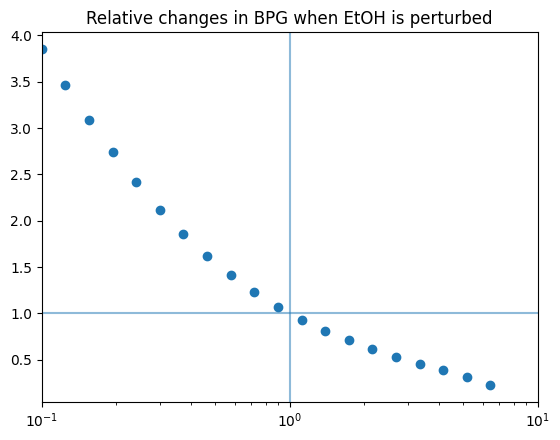

In [140]:
plt.scatter(EtOH_scale, calculate_relative_change('BPG'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in BPG when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

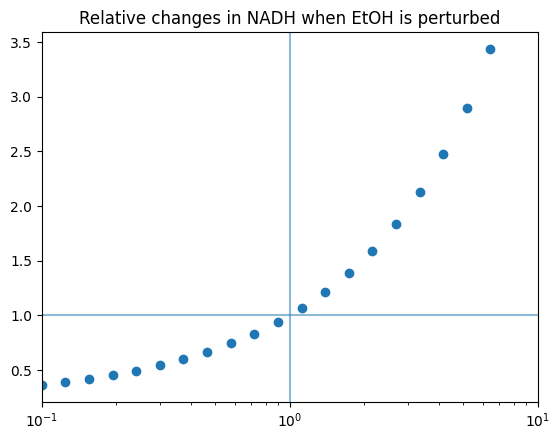

In [141]:
plt.scatter(EtOH_scale, calculate_relative_change('NADH'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in NADH when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

## Plotting changes in steady state fluxes due to changes in boundary species using parameters derived from the model using tellurium

Plotting relative changes in EtOH by relative changes in steady state fluxes *when fully parameterized*

In [2]:
ETOH_data_file = 'data/interim/generated_data/EtOHcompilation.csv'
ETOH_data = pd.read_csv(ETOH_data_file)

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, ETOH_data_file)
r.steadyState()
Ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [3]:
a = ETOH_data['ETOH']/50
a.drop(a.index[0],inplace=True)

# fp_EtOH_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@np.log(BIOMD64.xn).T + Ey@np.log(BIOMD64.yn).T)
fp_EtOH_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@(BIOMD64.xn).T + Ey@(BIOMD64.yn).T)

fp_EtOH_perturbed_fluxes_df = pd.DataFrame(fp_EtOH_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
fp_EtOH_perturbed_fluxes_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,89.538829,89.050013,88.760670,88.573335,88.447078,88.360065,88.299265,88.256397,88.225986,88.204322,88.188844,88.177762,88.169816,88.164113,88.149527,88.135024,88.129397,88.121598,88.110802,88.095874,88.075275,88.046922,88.008033,87.954946,87.882936,87.786074,87.657214,87.488225,87.270696,86.997417
vPGI,81.687774,79.350710,78.429631,77.987394,77.748907,77.609807,77.523996,77.468842,77.432302,77.407546,77.390497,77.378612,77.370254,77.364338,77.349527,77.335245,77.329822,77.322416,77.312370,77.298871,77.280982,77.257731,77.228365,77.192823,77.152605,77.112087,77.080232,77.072171,77.109424,77.216715
vGLYCO,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
vTreha,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000,2.400000
vPFK,85.884403,81.272057,79.343759,78.434288,77.971321,77.721826,77.580871,77.497877,77.447179,77.415188,77.394427,77.380635,77.371295,77.364874,77.349527,77.335795,77.330878,77.324441,77.316254,77.306322,77.295252,77.285004,77.280320,77.291363,77.338361,77.459419,77.722860,78.245356,79.216506,80.929916
vALD,78.750360,78.223722,77.942235,77.762709,77.641283,77.556976,77.497638,77.455545,77.425542,77.404091,77.388724,77.377700,77.369784,77.364096,77.349527,77.335007,77.329364,77.321535,77.310679,77.295637,77.274816,77.246031,77.206303,77.151579,77.076371,76.973256,76.832162,76.639266,76.375155,76.011479
vGAPDH,146.909859,142.544569,140.401384,139.130150,138.314436,137.768836,137.394888,137.134599,136.951536,136.821885,136.729651,136.663831,136.616708,136.582952,136.496807,136.411409,136.378369,136.332591,136.269362,136.182200,136.062318,135.898158,135.674424,135.371607,134.965376,134.426323,133.720604,132.811095,131.658705,130.222427
vPGK,196.936942,161.597820,148.722038,143.006675,140.187006,138.694566,137.859006,137.368830,137.070645,136.883373,136.761577,136.679872,136.625442,136.587449,136.496807,136.415745,136.385895,136.348559,136.300047,136.240013,136.173350,136.108260,136.072837,136.121087,136.360013,136.992815,138.373435,141.091450,146.084403,154.772348
vPGM,147.365929,142.627279,140.418553,139.133106,138.314336,137.768308,137.394454,137.134300,136.951356,136.821796,136.729610,136.663796,136.616702,136.582951,136.496807,136.411403,136.378335,136.332563,136.269316,136.182073,136.062082,135.897654,135.673404,135.369514,134.960950,134.417015,133.701021,132.770204,131.574887,130.055434
vENO,148.366780,142.972531,140.560034,139.196316,138.344018,137.782688,137.401569,137.137868,136.953160,136.822721,136.730085,136.664042,136.616830,136.583012,136.496807,136.411466,136.378456,136.332799,136.269758,136.182925,136.063701,135.900703,135.679133,135.380145,134.980437,134.452087,133.762783,132.876020,131.750393,130.335964


In [4]:
rel_fp_EtOH_perturbed_fluxes_df = fp_EtOH_perturbed_fluxes_df.div(fp_EtOH_perturbed_fluxes_df[1.00], axis=0)
# rel_fp_EtOH_perturbed_fluxes_df

In [5]:
vis_EtOH_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)

vis_EtOH_perturbed_fluxes_df = pd.DataFrame(vis_EtOH_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# vis_EtOH_perturbed_fluxes_df

In [6]:
vis_EtOH_perturbed_fluxes_df[1.00]

vGLK       88.149527
vPGI       77.349527
vGLYCO      6.000000
vTreha      2.400000
vPFK       77.349527
vALD       77.349527
vGAPDH    136.496807
vPGK      136.496807
vPGM      136.496807
vENO      136.496807
vPYK      136.496807
vPDC      136.496807
vSUC        3.640449
vGLT       88.149527
vADH      129.215909
vG3PDH     18.202246
vATP       84.532764
Name: 1.0, dtype: float64

In [7]:
rel_vis_EtOH_perturbed_fluxes_df = vis_EtOH_perturbed_fluxes_df.div(vis_EtOH_perturbed_fluxes_df[1.00], axis=0)
# rel_vis_EtOH_perturbed_fluxes_df

In [8]:
real_ETOH_values = ETOH_data[[i for i in ETOH_data.columns if 'v_' in i]]
rel_real_ETOH_values = real_ETOH_values.div(real_ETOH_values.iloc[0])
rel_real_ETOH_values.drop(rel_real_ETOH_values.index[0], inplace=True)
rel_real_ETOH_values.columns = r.getReactionIds()
rel_real_ETOH_values = rel_real_ETOH_values.transpose()
rel_real_ETOH_values.columns = a.round(2).values
rel_real_ETOH_values


,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,1.013158,1.009094,1.006402,1.004547,1.003245,1.002322,1.001665,1.001195,1.000858,1.000617,1.000444,1.000319,1.000230,1.000165,1.0,0.999835,0.999771,0.999682,0.999558,0.999387,0.999149,0.998819,0.998363,0.997732,0.996860,0.995658,0.994002,0.991724,0.988587,0.984251
vPGI,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vALD,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGAPDH,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGK,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGM,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vENO,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890


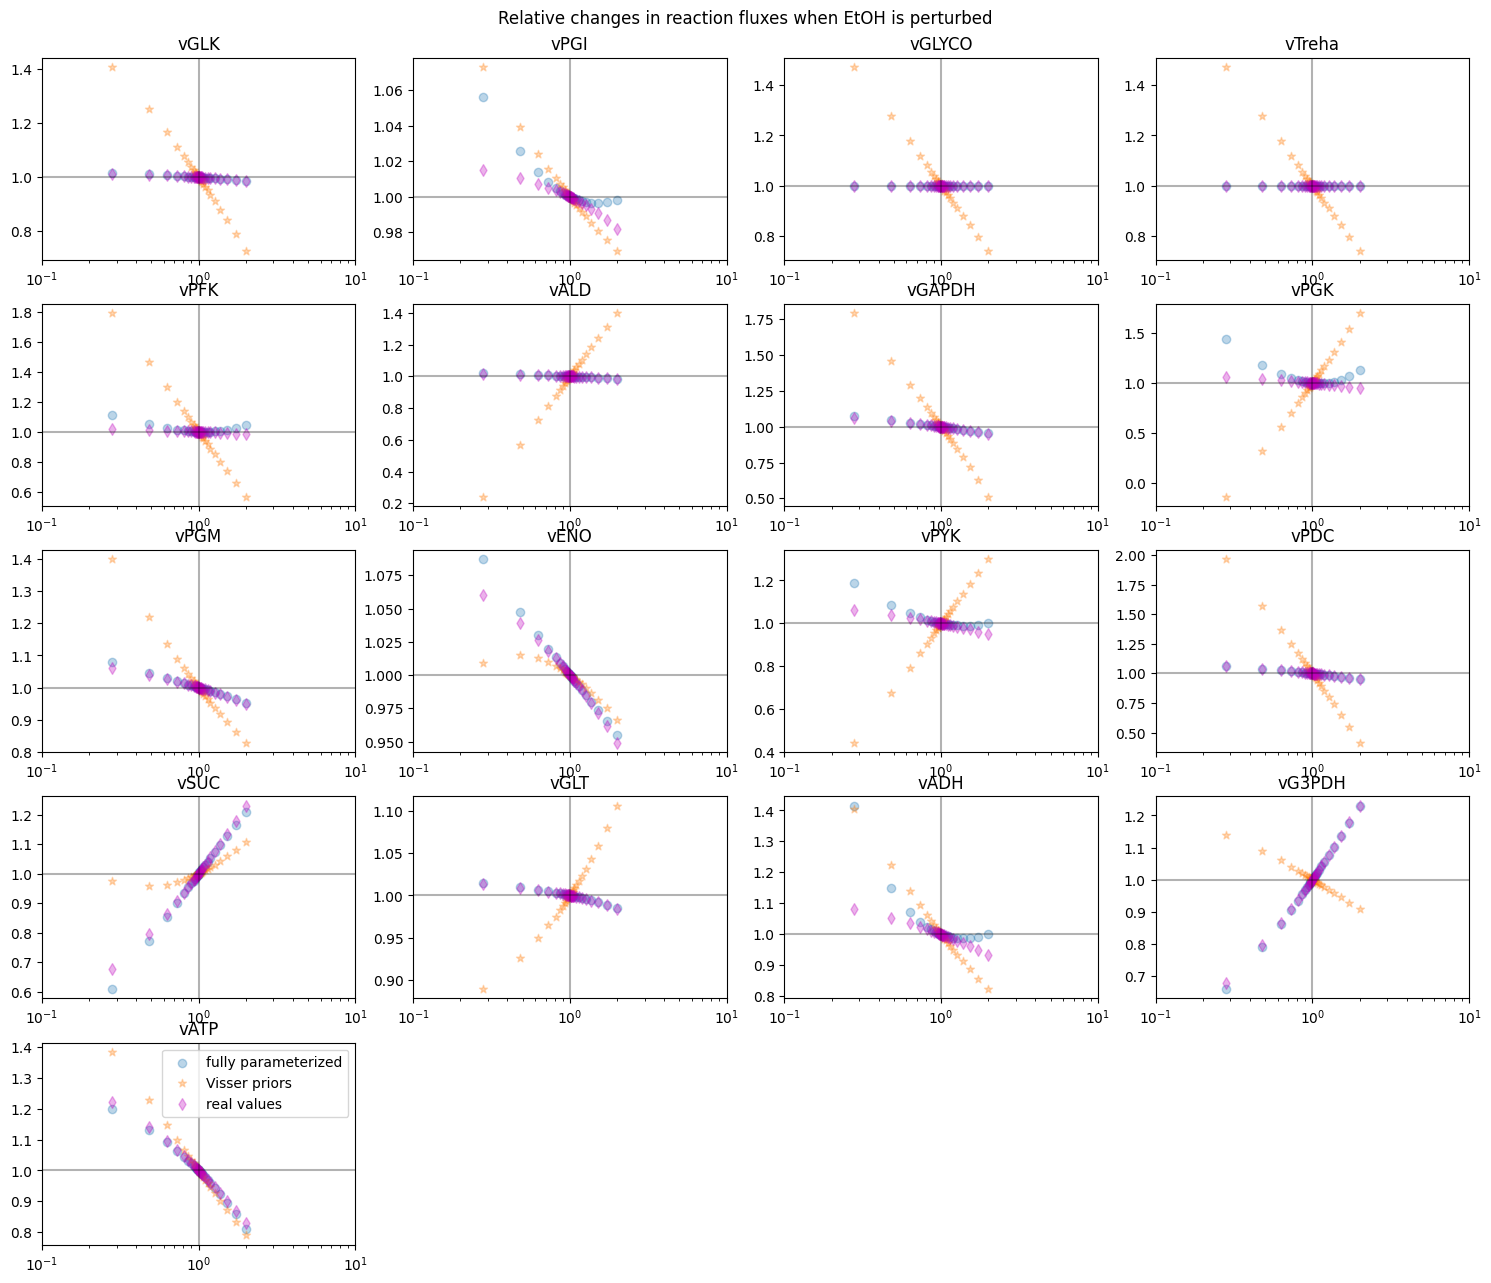

In [9]:
fig, axs = plt.subplots(5,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when EtOH is perturbed\n')
fig.tight_layout()

for i, rxn in enumerate(r.getReactionIds()):
  if i%4==0:
    idx_starter += 1
  
  axs[idx_starter, i%4].scatter(rel_fp_EtOH_perturbed_fluxes_df.columns, rel_fp_EtOH_perturbed_fluxes_df.loc[rxn], alpha=0.3)
  axs[idx_starter, i%4].scatter(rel_vis_EtOH_perturbed_fluxes_df.columns, rel_vis_EtOH_perturbed_fluxes_df.loc[rxn], alpha=0.3, marker='*')
  axs[idx_starter, i%4].scatter(rel_real_ETOH_values.columns, rel_real_ETOH_values.loc[rxn], alpha=0.3, c='m', marker='d')
  axs[idx_starter, i%4].set_xscale('log', base=10)
  axs[idx_starter, i%4].set_xlim([0.1, 10])
  axs[idx_starter, i%4].set_title(rxn)
  axs[idx_starter, i%4].axvline(1, alpha=0.3, color='k')
  axs[idx_starter, i%4].axhline(1, alpha=0.3, color='k')

fig.delaxes(axs[4,1]) 
fig.delaxes(axs[4,2]) 
fig.delaxes(axs[4,3]) 

plt.legend(["fully parameterized", "Visser priors", "real values"])
plt.show()

Plotting relative changes in GLY by relative changes in steady state fluxes *when fully parameterized*

In [10]:
GLY_data_file = 'data/interim/generated_data/GLYcompilation.csv'
GLY_data = pd.read_csv(GLY_data_file)

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, GLY_data_file)
r.steadyState()
Ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [11]:
a = GLY_data['GLY']/0.15
a.drop(a.index[0],inplace=True)

fp_GLY_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@(BIOMD64.xn).T + Ey@(BIOMD64.yn).T)

fp_GLY_perturbed_fluxes_df = pd.DataFrame(fp_GLY_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# fp_GLY_perturbed_fluxes_df

In [12]:
fp_rel_GLY_perturbed_fluxes_df = fp_GLY_perturbed_fluxes_df.div(fp_GLY_perturbed_fluxes_df[1.00], axis=0)
# fp_rel_GLY_perturbed_fluxes_df

In [13]:
vis_GLY_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)

vis_GLY_perturbed_fluxes_df = pd.DataFrame(vis_GLY_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# vis_GLY_perturbed_fluxes_df

In [14]:
vis_rel_GLY_perturbed_fluxes_df = vis_GLY_perturbed_fluxes_df.div(vis_GLY_perturbed_fluxes_df[1.00], axis=0)
# vis_rel_GLY_perturbed_fluxes_df

In [15]:
real_GLY_values = GLY_data[[i for i in GLY_data.columns if 'v_' in i]]
rel_real_GLY_values = real_GLY_values.div(real_GLY_values.iloc[0])
rel_real_GLY_values.drop(rel_real_GLY_values.index[0], inplace=True)
rel_real_GLY_values.columns = r.getReactionIds()
rel_real_GLY_values = rel_real_GLY_values.transpose()
rel_real_GLY_values.columns = a.round(2).values
rel_real_GLY_values


,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,0.998869,0.999198,0.999429,0.999593,0.999708,0.999791,0.999850,0.999892,0.999923,0.999944,0.999960,0.999971,0.999979,0.999985,1.0,1.000015,1.000021,1.000029,1.000040,1.000055,1.000077,1.000107,1.000148,1.000205,1.000283,1.000392,1.000540,1.000743,1.001018,1.001388
vPGI,0.998711,0.999086,0.999350,0.999536,0.999668,0.999762,0.999829,0.999877,0.999912,0.999937,0.999954,0.999967,0.999976,0.999983,1.0,1.000017,1.000024,1.000033,1.000045,1.000063,1.000088,1.000121,1.000168,1.000233,1.000323,1.000446,1.000616,1.000847,1.001160,1.001581
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,0.998711,0.999086,0.999350,0.999536,0.999668,0.999762,0.999829,0.999877,0.999912,0.999937,0.999954,0.999967,0.999976,0.999983,1.0,1.000017,1.000024,1.000033,1.000045,1.000063,1.000088,1.000121,1.000168,1.000233,1.000323,1.000446,1.000616,1.000847,1.001160,1.001581
vALD,0.998711,0.999086,0.999350,0.999536,0.999668,0.999762,0.999829,0.999877,0.999912,0.999937,0.999954,0.999967,0.999976,0.999983,1.0,1.000017,1.000024,1.000033,1.000045,1.000063,1.000088,1.000121,1.000168,1.000233,1.000323,1.000446,1.000616,1.000847,1.001160,1.001581
vGAPDH,0.995732,0.996964,0.997833,0.998449,0.998889,0.999203,0.999427,0.999589,0.999704,0.999787,0.999847,0.999890,0.999921,0.999943,1.0,1.000057,1.000079,1.000110,1.000153,1.000212,1.000294,1.000408,1.000566,1.000785,1.001088,1.001505,1.002080,1.002868,1.003943,1.005399
vPGK,0.995732,0.996964,0.997833,0.998449,0.998889,0.999203,0.999427,0.999589,0.999704,0.999787,0.999847,0.999890,0.999921,0.999943,1.0,1.000057,1.000079,1.000110,1.000153,1.000212,1.000294,1.000408,1.000566,1.000785,1.001088,1.001505,1.002080,1.002868,1.003943,1.005399
vPGM,0.995732,0.996964,0.997833,0.998449,0.998889,0.999203,0.999427,0.999589,0.999704,0.999787,0.999847,0.999890,0.999921,0.999943,1.0,1.000057,1.000079,1.000110,1.000153,1.000212,1.000294,1.000408,1.000566,1.000785,1.001088,1.001505,1.002080,1.002868,1.003943,1.005399
vENO,0.995732,0.996964,0.997833,0.998449,0.998889,0.999203,0.999427,0.999589,0.999704,0.999787,0.999847,0.999890,0.999921,0.999943,1.0,1.000057,1.000079,1.000110,1.000153,1.000212,1.000294,1.000408,1.000566,1.000785,1.001088,1.001505,1.002080,1.002868,1.003943,1.005399


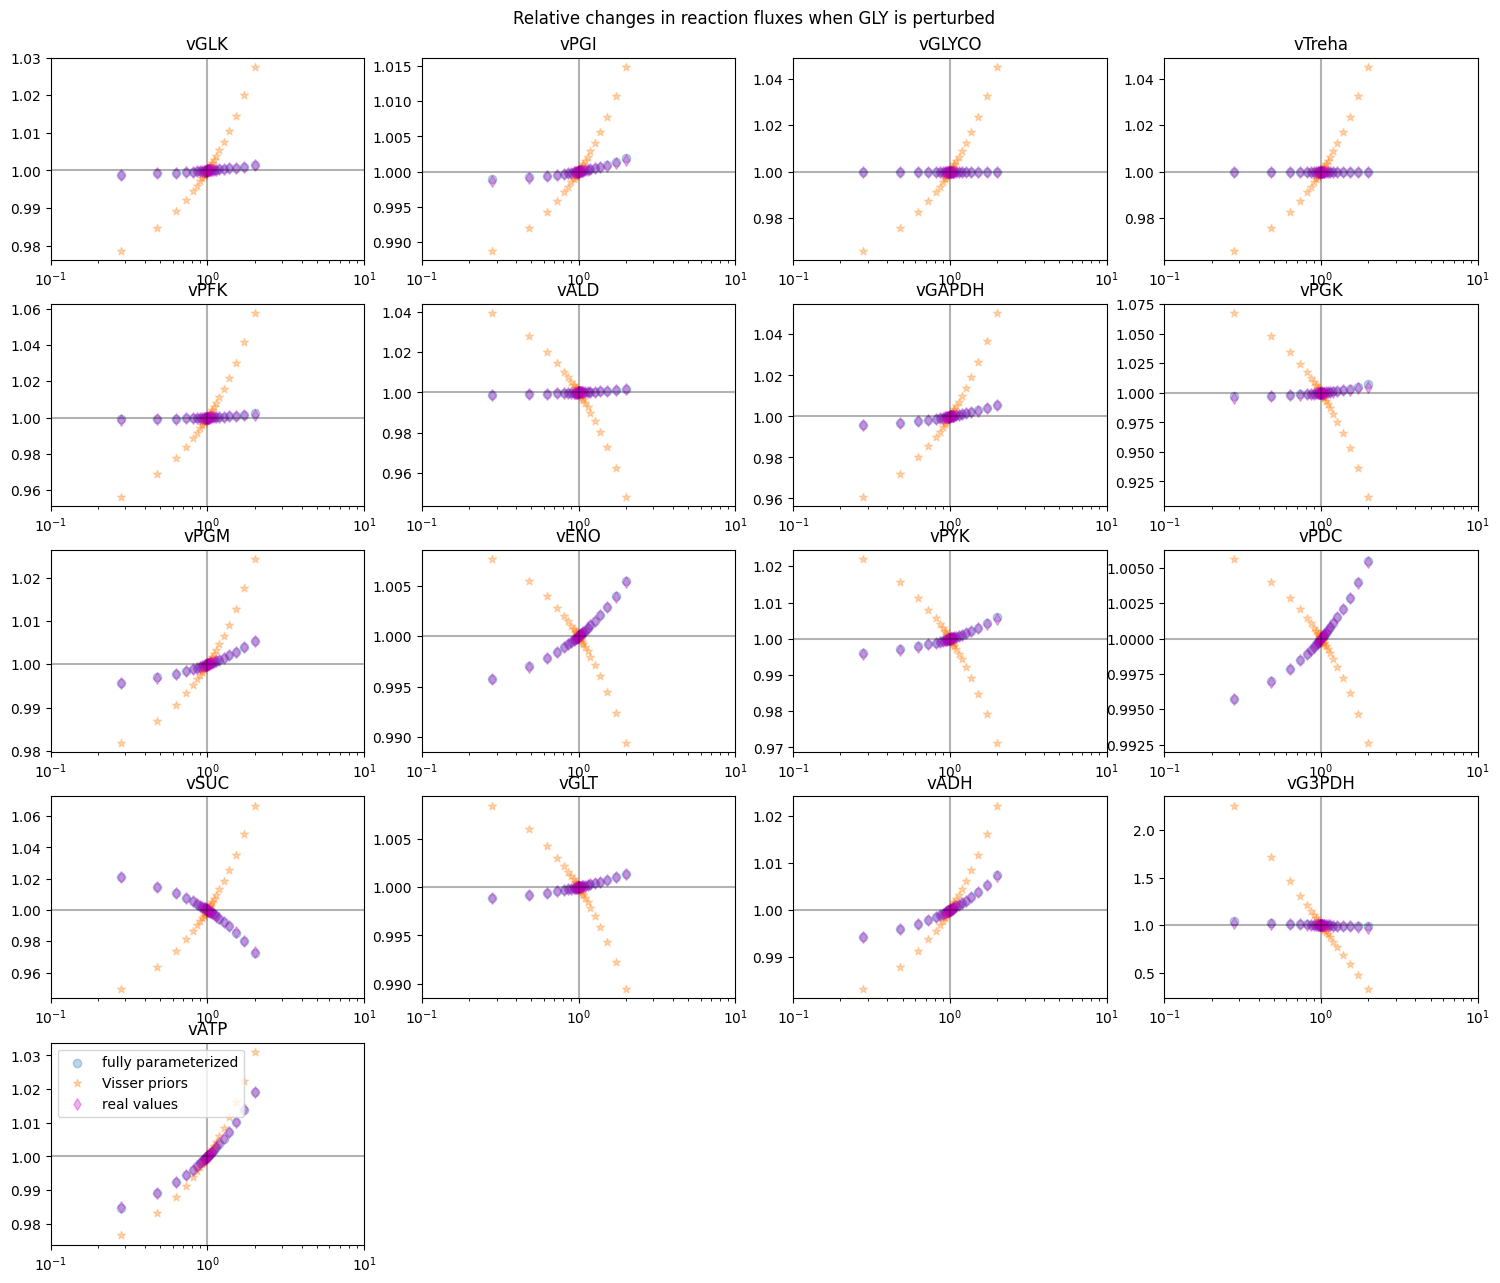

In [16]:
fig, axs = plt.subplots(5,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when GLY is perturbed\n')
fig.tight_layout()

for i, rxn in enumerate(r.getReactionIds()):
  if i%4==0:
    idx_starter += 1
  
  axs[idx_starter, i%4].scatter(fp_rel_GLY_perturbed_fluxes_df.columns, fp_rel_GLY_perturbed_fluxes_df.loc[rxn], alpha=0.3)
  axs[idx_starter, i%4].scatter(vis_rel_GLY_perturbed_fluxes_df.columns, vis_rel_GLY_perturbed_fluxes_df.loc[rxn], alpha=0.3, marker='*')
  axs[idx_starter, i%4].scatter(rel_real_GLY_values.columns, rel_real_GLY_values.loc[rxn], alpha=0.3, c='m', marker='d')
  axs[idx_starter, i%4].set_xscale('log', base=10)
  axs[idx_starter, i%4].set_xlim([0.1, 10])
  axs[idx_starter, i%4].set_title(rxn)
  axs[idx_starter, i%4].axvline(1, alpha=0.3, c='k')
  axs[idx_starter, i%4].axhline(1, alpha=0.3, c='k')

fig.delaxes(axs[4,1]) 
fig.delaxes(axs[4,2]) 
fig.delaxes(axs[4,3]) 

plt.legend(["fully parameterized", "Visser priors", "real values"])
plt.show()

Plotting relative changes in GLCo by relative changes in steady state fluxes *when fully parameterized*

In [17]:
GLCo_data_file = 'data/interim/generated_data/GLCocompilation.csv'
GLCo_data = pd.read_csv(GLCo_data_file)

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, GLCo_data_file)
r.steadyState()
Ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [18]:
a = GLCo_data['GLCo']/50
a.drop(a.index[0],inplace=True)

fp_GLCo_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@(BIOMD64.xn).T + Ey@(BIOMD64.yn).T)

fp_GLCo_perturbed_fluxes_df = pd.DataFrame(fp_GLCo_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# GLCo_perturbed_fluxes_df

In [19]:
fp_rel_GLCo_perturbed_fluxes_df = fp_GLCo_perturbed_fluxes_df.div(fp_GLCo_perturbed_fluxes_df[1.00], axis=0)
# fp_rel_GLCo_perturbed_fluxes_df

In [20]:
vis_GLCo_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)

vis_GLCo_perturbed_fluxes_df = pd.DataFrame(vis_GLCo_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# vis_GLCo_perturbed_fluxes_df

In [21]:
vis_rel_GLCo_perturbed_fluxes_df = vis_GLCo_perturbed_fluxes_df.div(vis_GLCo_perturbed_fluxes_df[1.00], axis=0)
# vis_rel_GLCo_perturbed_fluxes_df

In [22]:
real_GLCo_values = GLCo_data[[i for i in GLCo_data.columns if 'v_' in i]]
rel_real_GLCo_values = real_GLCo_values.div(real_GLCo_values.iloc[0])
rel_real_GLCo_values.drop(rel_real_GLCo_values.index[0], inplace=True)
rel_real_GLCo_values.columns = r.getReactionIds()
rel_real_GLCo_values = rel_real_GLCo_values.transpose()
rel_real_GLCo_values.columns = a.round(2).values
rel_real_GLCo_values


,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,0.939113,0.973712,0.985311,0.990894,0.994041,0.995974,0.997225,0.998062,0.998634,0.999031,0.999310,0.999507,0.999647,0.999747,1.0,1.000248,1.000343,1.000474,1.000654,1.000900,1.001234,1.001683,1.002280,1.003062,1.004065,1.005320,1.006838,1.008606,1.010572,1.012654
vPGI,0.930612,0.970042,0.983260,0.989622,0.993209,0.995412,0.996838,0.997791,0.998443,0.998896,0.999214,0.999439,0.999598,0.999712,1.0,1.000283,1.000391,1.000541,1.000746,1.001026,1.001406,1.001918,1.002599,1.003490,1.004633,1.006063,1.007793,1.009807,1.012049,1.014421
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,0.930612,0.970042,0.983260,0.989622,0.993209,0.995412,0.996838,0.997791,0.998443,0.998896,0.999214,0.999439,0.999598,0.999712,1.0,1.000283,1.000391,1.000541,1.000746,1.001026,1.001406,1.001918,1.002599,1.003490,1.004633,1.006063,1.007793,1.009807,1.012049,1.014421
vALD,0.930612,0.970042,0.983260,0.989622,0.993209,0.995412,0.996838,0.997791,0.998443,0.998896,0.999214,0.999439,0.999598,0.999712,1.0,1.000283,1.000391,1.000541,1.000746,1.001026,1.001406,1.001918,1.002599,1.003490,1.004633,1.006063,1.007793,1.009807,1.012049,1.014421
vGAPDH,0.926153,0.968125,0.982192,0.988961,0.992777,0.995120,0.996636,0.997651,0.998344,0.998826,0.999164,0.999403,0.999573,0.999694,1.0,1.000300,1.000416,1.000575,1.000793,1.001091,1.001496,1.002040,1.002764,1.003711,1.004927,1.006447,1.008287,1.010428,1.012811,1.015332
vPGK,0.926153,0.968125,0.982192,0.988961,0.992777,0.995120,0.996636,0.997651,0.998344,0.998826,0.999164,0.999403,0.999573,0.999694,1.0,1.000300,1.000416,1.000575,1.000793,1.001091,1.001496,1.002040,1.002764,1.003711,1.004927,1.006447,1.008287,1.010428,1.012811,1.015332
vPGM,0.926153,0.968125,0.982192,0.988961,0.992777,0.995120,0.996636,0.997651,0.998344,0.998826,0.999164,0.999403,0.999573,0.999694,1.0,1.000300,1.000416,1.000575,1.000793,1.001091,1.001496,1.002040,1.002764,1.003711,1.004927,1.006447,1.008287,1.010428,1.012811,1.015332
vENO,0.926153,0.968125,0.982192,0.988961,0.992777,0.995120,0.996636,0.997651,0.998344,0.998826,0.999164,0.999403,0.999573,0.999694,1.0,1.000300,1.000416,1.000575,1.000793,1.001091,1.001496,1.002040,1.002764,1.003711,1.004927,1.006447,1.008287,1.010428,1.012811,1.015332


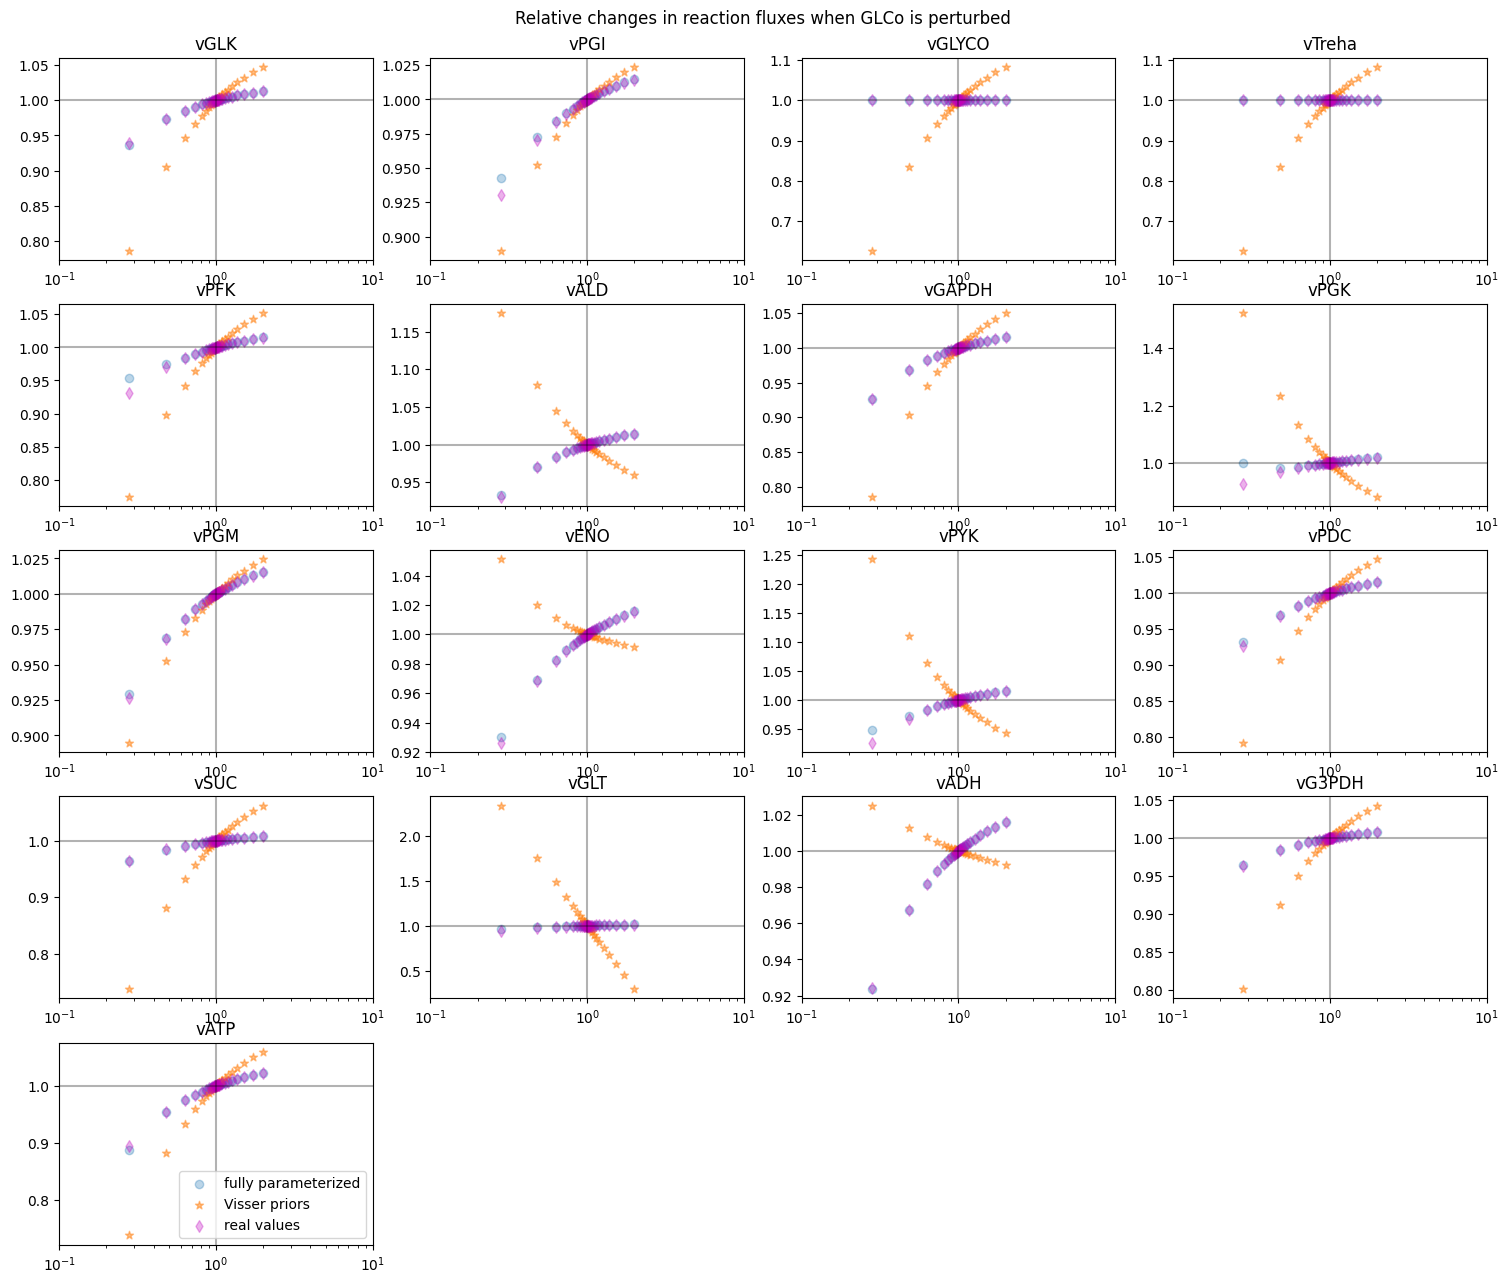

In [23]:
fig, axs = plt.subplots(5,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when GLCo is perturbed\n')
fig.tight_layout()

for i, rxn in enumerate(r.getReactionIds()):
  if i%4==0:
    idx_starter += 1
  
  axs[idx_starter, i%4].scatter(fp_rel_GLCo_perturbed_fluxes_df.columns, fp_rel_GLCo_perturbed_fluxes_df.loc[rxn], alpha=0.3)
  axs[idx_starter, i%4].scatter(vis_rel_GLCo_perturbed_fluxes_df.columns, vis_rel_GLCo_perturbed_fluxes_df.loc[rxn], alpha=0.5, marker='*')
  axs[idx_starter, i%4].scatter(rel_real_GLCo_values.columns, rel_real_GLCo_values.loc[rxn], alpha=0.3, c='m', marker='d')
  axs[idx_starter, i%4].set_xscale('log', base=10)
  axs[idx_starter, i%4].set_xlim([0.1, 10])
  axs[idx_starter, i%4].set_title(rxn)
  axs[idx_starter, i%4].axvline(1, alpha=0.3, c='k')
  axs[idx_starter, i%4].axhline(1, alpha=0.3, c='k')

fig.delaxes(axs[4,1]) 
fig.delaxes(axs[4,2]) 
fig.delaxes(axs[4,3]) 

plt.legend(["fully parameterized", "Visser priors", "real values"])
plt.show()

## Using Bayesian inference to determine linlog fluxes 

In [ ]:
from src import BMCA, util
import tellurium as te

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
data_file = 'data/interim/generated_data/EtOHcompilation.csv'

r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)



In [2]:
N_ITERATIONS = 1000
import numpy as np
import pymc as pm


with pm.Model() as pymc_model:
    
    # Initialize elasticities
    
    # Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))


# with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

TypeError: Model does not have an free RVs

In [ ]:

Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))

    trace_prior = pm.sample_prior_predictive(samples=1000)
    
    e_obs = pm.Normal('e_obs', mu=BIOMD64.en, sigma=0.1, observed=BIOMD64.en)
    
    chi_obs = pm.Normal('chi_obs', mu=BIOMD64.xn, sigma=0.1, observed=BIOMD64.xn)
    y_obs = pm.Normal('y_obs', mu=BIOMD64.yn, sigma=0.1, observed=BIOMD64.yn)
    
    v_hat_obs = pm.Normal('v_hat_obs', mu=BIOMD64.vn.squeeze(),
                        sigma=0.1, observed=BIOMD64.vn.squeeze())